In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob

In [3]:
files = glob.glob("../data/viirs/*.jpeg")

In [4]:
images = []
for file in files:
    img = np.array(mpimg.imread(file), dtype=float) / 255.
    csum = np.sum(img, axis=-1)
    img[csum == 0] = [np.nan, np.nan, np.nan]
    images.append(img)
images = np.array(images)

In [5]:
avg = np.nanmean(images, axis=0)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [6]:
avg_grey = np.nansum(avg, axis=-1) / 3.

In [7]:
avg_grey[avg_grey < 0.05] = 1

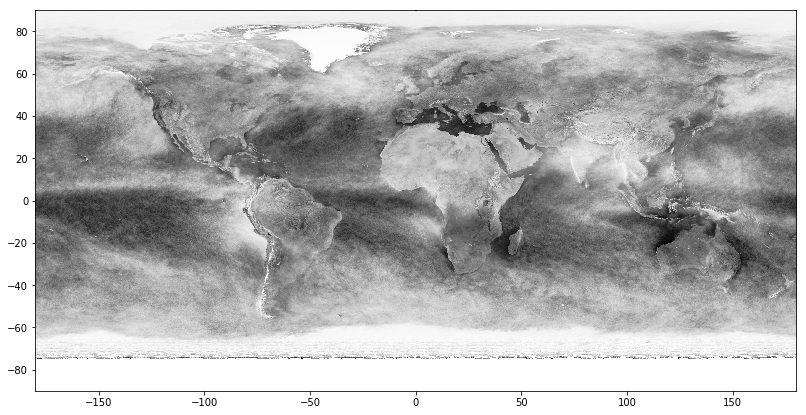

In [8]:
fig, ax = plt.subplots(1, figsize=(14, 7))
ax.imshow(avg_grey, extent=(-180, 180, -90, 90), cmap="Greys_r");

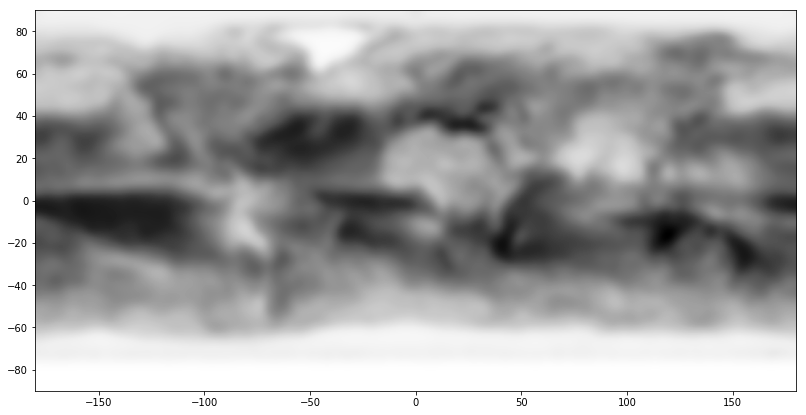

In [26]:
from scipy import ndimage
blurred = ndimage.gaussian_filter(avg_grey, sigma=30)
blurred = (blurred - blurred.min()) / (blurred.max() - blurred.min())
fig, ax = plt.subplots(1, figsize=(14, 7))
ax.imshow(blurred, extent=(-180, 180, -90, 90), cmap="Greys_r", vmin=0, vmax=1);

In [27]:
import starry_beta
map = starry_beta.Map(25)
map.load_image(blurred)
yearth = np.array(map.y)

import starry
map = starry.Map(25)
map[:, :] = yearth
Z = map.render(projection="rect")

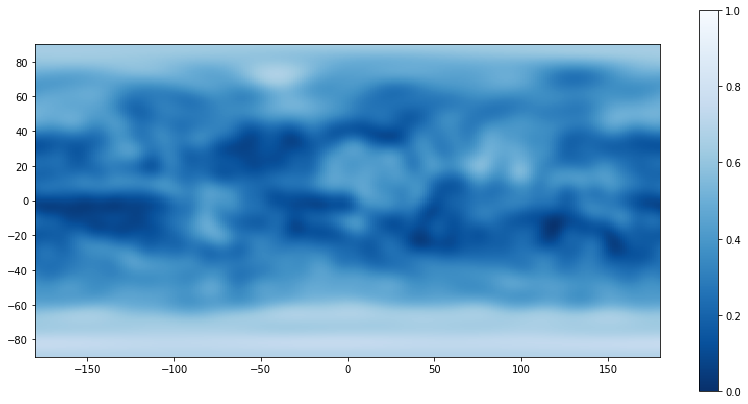

In [29]:
fig, ax = plt.subplots(1, figsize=(14, 7))
im = plt.imshow(Z[0], extent=(-180, 180, -90, 90), cmap="Blues_r", origin="lower", vmin=0, vmax=1);
plt.colorbar(im);

In [30]:
Z[0].min(), Z[0].max()

(0.013459565562446846, 0.7472655861507391)

In [31]:
np.savez("../data/earth_true_sector1.npz", y=yearth)

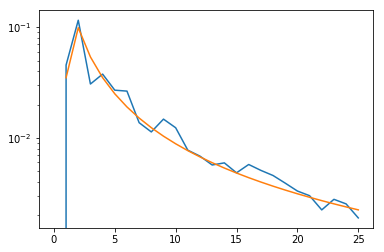

In [33]:
def std(l, a=2.0, b=1.5, c=0.035):
    if l == 0:
        return np.nan
    elif l < a:
        return c * l ** b
    else:
        return c * a ** (2 * b) * l ** -b
    
ls = np.arange(map.ydeg + 1)
plt.plot(ls, [np.std(map[l, :]) for l in ls])
plt.plot(ls, [std(l) for l in ls])
plt.yscale("log")